#### Last Modified: Dec 13th, 2021 (Opal). 

# Shifted-OpInf on 2D Spherical Coordinates MHD Solar Wind Radial Speed


In [1]:
import os
curr_dir = os.getcwd()
os.chdir("../")
print("current directory path = ", os.getcwd())

current directory path =  /Users/oissan/PycharmProjects/Space-Weather-ROM


In [2]:
import numpy as np
import scipy
import scipy.linalg as la
from scipy import signal
import scipy.sparse as sparse
from scipy.interpolate import interp1d, interp2d
from scipy.integrate import solve_ivp
from tools.MASweb import get_mas_path
from psipy.model import MASOutput
from psipy.data import sample_data
from psipy.model.variable import Variable
import rom_operator_inference as roi
from scipy.interpolate import interp1d, interp2d
from scipy.interpolate import RegularGridInterpolator
from scipy import stats
import numpy as np 
import time
import astropy.units as u
import cv2

In [3]:
import matplotlib.pyplot as plt
import matplotlib
font = {'family' : 'serif',
        'size'   : 13}

matplotlib.rc('font', **font)
matplotlib.rc('xtick', labelsize=13) 
matplotlib.rc('ytick', labelsize=13) 

# Import MHD solar wind radial velocity results.

In [4]:
# mas output - br, rho, vr
cr = "2210"
mas_path = get_mas_path(cr=cr)
model = MASOutput(mas_path)
print(model.variables)
# get back to original directory
os.chdir(curr_dir)

['br', 'rho', 'vr']


In [5]:
# read in MHD velocity results. 
vr_model = model['vr']

In [6]:
# save MHD mesh coordinates Heliographic (rotating) Coordinate System (HG)
# phi - (0, 2pi)
p = vr_model.phi_coords
# number of phi indexes 
n = len(p)
# delta phi
dp = p[1:] - p[:-1]
# sin(theta) - (-pi/2, pi/2)
t = vr_model.theta_coords
# 30 solar radii to approximately 1 AU
# 1 solar radii = 695,700 km
r = (vr_model.r_coords * u.solRad).to(u.km)
# change in r
dr = r[1:] - r[:-1]
# velocity profile 
f = vr_model.data
print(f.shape)

(128, 111, 140)


In [7]:
# force periodicity on f
# since the last phi index is less than 2*pi, then we will append 2*pi to phi scale.
p = np.append(p, 2*np.pi) 

# append the first slice p=0 to velocity matrix. 
f = np.append(f,[f[0,:, :]],axis=0)

# save radial velocity 
V = np.array(f)

In [8]:
PlotSlices = False
if PlotSlices == True:
    for ii in np.arange(len(r)):
        fig, ax = plt.subplots(figsize=(11, 5))
        im = ax.imshow(f[:, :, ii].T,
                    extent=[p[0]*180/np.pi, p[-1]*180/np.pi, t[0]*180/np.pi, t[-1]*180/np.pi],   
                    vmin = 300, vmax = 700, cmap="viridis", aspect="auto", origin="lower")

        ax.set_title("$V_{r}$, r = " + str(round(r[ii].to(u.AU).value, 2)) + " AU")
        ax.set_yticks([-90, -45, 0, 45, 90])
        ax.set_xticks([0, 90, 180, 270, 360])
        ax.set_xlabel("Carrington Longitude (Deg.)")
        ax.set_ylabel("Latitude (Deg.)")
        cbar = fig.colorbar(im, ax=ax)
        cbar.ax.set_ylabel('km/s', rotation=90)
        file_name = "figs/Animation/fig_" + str(ii) + ".png"
        fig.savefig(file_name, dpi=500)

In [9]:
SaveVid = False

if SaveVid:
    # choose codec according to format needed
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    video = cv2.VideoWriter("sw_vid.mov", fourcc, 30, (5500, 2500))
    # loop over save images. 
    for j in range(len(r)):
        file_name = "figs/Animation/fig_" + str(j) + ".png"
        img = cv2.imread(file_name)
        video.write(img)
    cv2.destroyAllWindows()
    video.release()

# Solar Wind

Due to the high temperature of the Sun's upper atmosphere, called the corona, particles are able to escape the Sun's gravity, resulting in the Solar Wind. The solar wind is a stream of charged particles mostly consists of electrons, protons and alpha particles. The solar wind varies in density, temperature and speed over time and over solar latitude and longitude.

Here we will model the radial velocity of the Solar Wind protons denoted by $v_{r}$. As the solar wind propagates out in the heliosphere it can reach velocities of around 300-700 km/sec. 

In [10]:
def plot_slices_fig(data, title="MHD CR2210", figsave="figs/mhd_2D_slices.png", vmin=300, vmax=700):
    fig = plt.figure(figsize=(10,12))
    for id_subplot, snapshot in enumerate(np.append(np.arange(0, len(r), 30), len(r)-1), start=1):
        plt.subplot(4, 2, id_subplot)
        im = plt.imshow(data[:, :, snapshot].T,  vmin=vmin, vmax=vmax, 
                        extent=[p[0]*180/np.pi, p[-1]*180/np.pi, t[0]*180/np.pi, t[-1]*180/np.pi],   
                     cmap="plasma", aspect="auto")
        plt.title("r = " + str(round(r[snapshot].to(u.AU).value, 3)) + " AU")
        plt.xlabel(r"$\phi$ (Deg.)", fontsize=14)
        plt.ylabel(r"$\theta$ (Deg.)", fontsize=14)
        plt.yticks([-90, -45, 0, 45, 90])
        plt.xticks([360, 270, 180, 90, 0])

    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([0.99, 0.3, 0.03, 0.6])
    fig.colorbar(im, cax=cbar_ax)

    _ = cbar_ax.set_ylabel('km/s', rotation=90)


    fig.suptitle(title)
    plt.tight_layout()

    fig.savefig(figsave, dpi=300, bbox_inches='tight')

/var/folders/tt/hgb4_vc13z77x5wpt5lzk5j40000gn/T/ipykernel_2281/2727364129.py:22: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


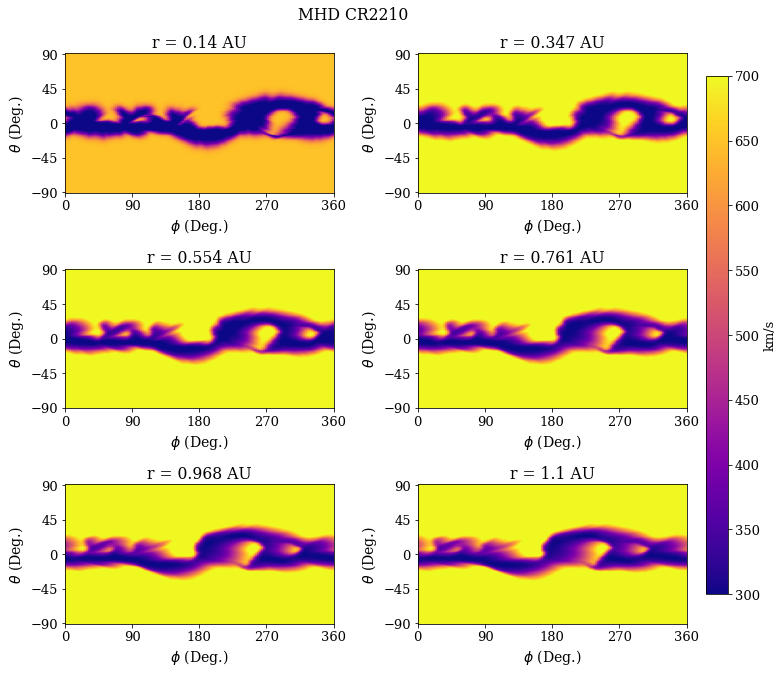

In [11]:
plot_slices_fig(data=f, title="MHD CR2210", figsave="figs/CR" + str(cr) +"/mhd_2d_slices.png")

In [12]:
def periodic_corr_2d(x, y):
    """Periodic correlation, implemented using np.correlate.

    x and y must be real sequences with the same length.
    """
    return scipy.signal.correlate2d(x, np.concatenate((y[1:, :], y)), mode='valid')

def normalize(x):
    return (x - np.mean(x))/np.std(x)

In [13]:
v1 = V[:, :, 0]

shift_vec = [0]

for ii in range(1, len(r)):
    v2 = V[:, :, ii]
    
    corr = periodic_corr_2d(normalize(v1), normalize(v2))
    corr = corr/np.max(corr)
    
    shift_vec.append(p[np.argmax(corr)]*180/np.pi)

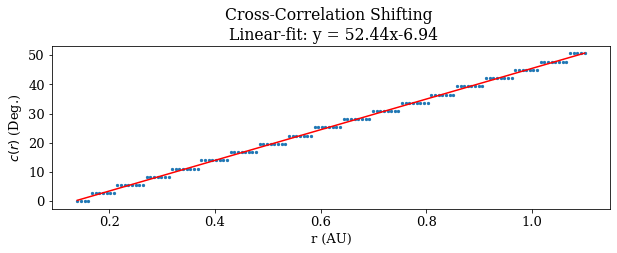

In [14]:
fig, ax = plt.subplots(figsize =(10, 3))
ax.scatter(r.to(u.AU), shift_vec, s=5)
m, b = np.polyfit(r[:int(0.7*len(r))].to(u.AU).value, shift_vec[:int(0.7*len(r))], 1)
_ = ax.plot(r.to(u.AU), m*r.to(u.AU).value + b, c="r", label="linear-fit")

_ = ax.set_xlabel("r (AU)")
_ = ax.set_ylabel("$c(r)$ (Deg.)")
_ = ax.set_title("Cross-Correlation Shifting \n Linear-fit: y = " + str(round(m, 2)) + "x" + str(round(b, 2)))

In [15]:
def shift_function(r, m, b):
    return m * r + b

In [16]:
def interp_fun(p_shifted, p, t, v):
    # interpolator. 
    my_interpolating_function = RegularGridInterpolator((p, t), v)
    # create new mesh grid. 
    points = np.meshgrid(p_shifted, t)
    # flatten the mesh grid points to align with input for RegularGridInterp function.
    flat = np.array([m.flatten() for m in points])
    # pass to the interp function.
    out_array = my_interpolating_function(flat.T)
    # reshape back to original grid. 
    return out_array.reshape(*points[0].shape)

In [17]:
# initialize the data matrix. 
V_new = np.zeros((len(p), len(t), len(r)))

# initial conditon. 
V_new[:, :, 0] = V[:, :, 0]

for jj in range(1, len(r)):
    # compute shift from the linear fit above. 
    shift = shift_function(r[jj].to(u.AU).value, m=m, b=b)
    # define the new shifted coordinate.
    x_new = (p*180/np.pi - shift) % (360)
    # interpolate over the shifted coordinate
    V_new[:, :, jj] = interp_fun(p_shifted=x_new, p=p*180/np.pi, t=t, v=V[:, :, jj]).T

/var/folders/tt/hgb4_vc13z77x5wpt5lzk5j40000gn/T/ipykernel_2281/2727364129.py:22: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


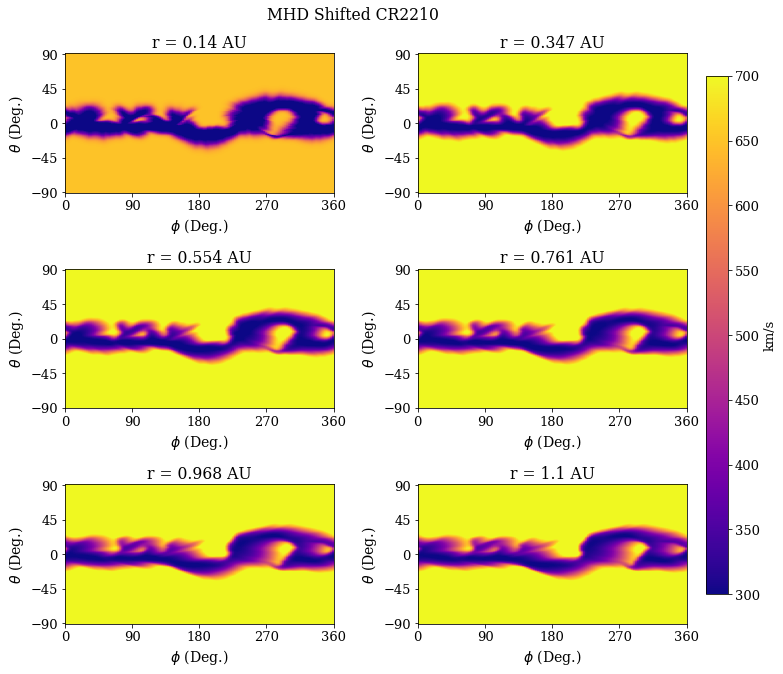

In [18]:
plot_slices_fig(data=V_new, title="MHD Shifted CR2210", figsave="figs/CR" + str(cr) + "/mhd_2D_shifted_slices.png")

# Split Training and Testing datasets. 

* Training = First $l$ radial indexes.
* Testing/Validation = Remaining $n_{r}-l$ radial indexes.

In [19]:
# set up the first l indexes used for training. 
l = int(0.7*(len(r)))

In [20]:
X = V_new

In [21]:
V_new.shape

(129, 111, 140)

In [22]:
X_train = V_new[:, :, :l]
X_test = V_new[:, :, l:-1]

In [23]:
r_train = r[:l]
r_test = r[l:-1]

In [24]:
print("X train shape", np.shape(X_train))
print("Radial distance train: " + str(r[0].to(u.AU)) + " to " + str(r[l].to(u.AU)))
print("\nX test shape", np.shape(X_test))
print("Radial distance test: " + str(r[l].to(u.AU)) + " to " + str(r[-1].to(u.AU)))

X train shape (129, 111, 98)
Radial distance train: 0.13951401782886472 AU to 0.816444039517221 AU

X test shape (129, 111, 41)
Radial distance test: 0.816444039517221 AU to 1.0996495197497314 AU


## Intrusive vs. non-intrustive ROM
* intrusive- ROM operators requires access to the discretized FOM operators.

* nonintrustive -learns ROMs from simulation data without direct access to the FOM operators. 

## Using the ROM Operator Inference Package
Since the FOM has the form
$$
    \frac{d}{dt}\mathbf{x}(t) = A \ln (\mathbf{x}(t)),\qquad\mathbf{x}(0) = \mathbf{x}_0,
$$
we seek a reduced model with that same structure,
$$
    \frac{d}{dt}\hat{\mathbf{x}}(t) = \hat{A}\hat{\mathbf{x}}(t),\qquad\hat{\mathbf{x}}(0) = \hat{\mathbf{x}}_0,
$$

but with $\hat{\mathbf{x}}\in \mathbb{R}^{r}$ and $\hat{A}\in\mathbb{R}^{r\times r}$ for some $r\ll n$. Esentially, we apply the **Dynamic Mode Decomposition (DMD)** method to predict the solar wind proton velocity at several heliocentric distances. 

We have several tasks to consider:
1. Choosing the reduced-model dimension $r$,
2. Constructing a low-dimensional subspace,
3. Computing the right-hand side data matrix $\dot{X}$,
4. Constructing the ROM via Operator Inference,
5. Simulating the ROM, and
6. Evaluating the performance of the ROM.

We will do this quickly, then show each step in more detail.

### Step 1: Choosing the Reduced-model Dimension
There are several ways to choose $r$ in an informed way.
A simple choice is to look at the singular values $\{\sigma_j\}_{j=1}^{n}$ of the snapshot matrix $X$ and select the number of $\sigma_{j}$ that are greater than a given threshold.
This also gives us a sense of whether or not we expect model reduction to be successful: if the singular values do not decay quickly, then we will need many modes to capture the behavior of the system.

In [25]:
def flatten(X):
    return X.reshape((len(p)*len(t), -1))
    

def undo_flatten(X):
    return X.reshape(len(p), len(t), -1)

In [26]:
svdvals = la.svdvals(flatten(X_train))
svdvals_prev = la.svdvals(flatten(V[:, :, :l]))

In [27]:
# Calculate the cumulative energy.
thresh = .999
cum_energy = np.cumsum(svdvals) / np.sum(svdvals)
cum_energy_prev = np.cumsum(svdvals_prev) / np.sum(svdvals_prev)

# Determine the points at which the cumulative energy passes the threshold.
rank = sum([rank < thresh for rank in cum_energy])
rank_prev = sum([rank < thresh for rank in cum_energy_prev])
print(f"r (Shifted coordinates)= {rank}")
print(f"r (Eularian coordinates)= {rank_prev}")

r (Shifted coordinates)= 17
r (Eularian coordinates)= 27


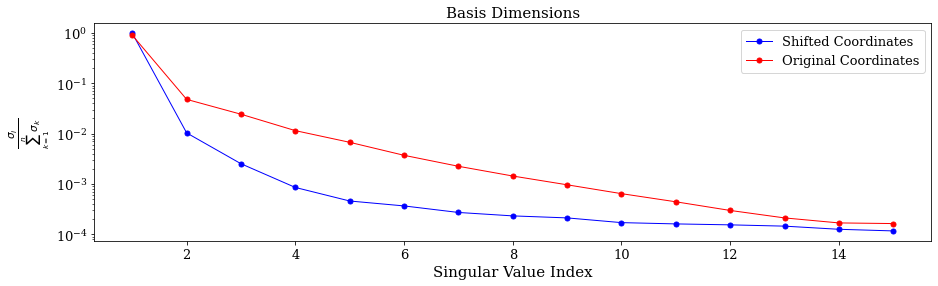

In [28]:
#Visualize cumulative energy and threshold value(s).
fig, ax = plt.subplots(figsize=(15, 4))
#plot singluar values cumulative energy
ax.plot(np.arange(1, 16), svdvals[:15]/ np.sum(svdvals), '.-', ms=10, lw=1, zorder=3, c="b", label="Shifted Coordinates")
ax.plot(np.arange(1, 16), svdvals_prev[:15]/ np.sum(svdvals_prev), '.-', ms=10, lw=1, zorder=3, c="r", label="Original Coordinates")

plt.yscale("log")
plt.legend()
_ = ax.set_xlabel(r"Singular Value Index", fontsize=15)
_ = ax.set_ylabel(r"$\frac{\sigma_{i}}{\sum_{k=1}^{n} \sigma_{k}}$", fontsize=15)
_ = ax.set_title("Basis Dimensions", fontsize=15)

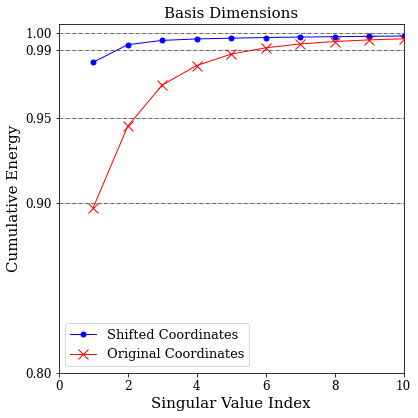

In [29]:
# Visualize cumulative energy and threshold value(s).
fig, ax = plt.subplots(figsize=(6, 6))

xlim= 10

# plot singluar values cumulative energy
ax.plot(np.arange(1, svdvals.size + 1), cum_energy, '.-', ms=10, lw=1, zorder=3, c="b", label="Shifted Coordinates")
ax.plot(np.arange(1, svdvals_prev.size + 1), cum_energy_prev, 'x-', ms=10, lw=1, zorder=3, c="r", label="Original Coordinates")
# get current y-limits 
ylim = ax.get_ylim()
# plot vertical and horizontal lines based on threshhold value
#ax.vlines(rank, 0, thresh, color="blue", linewidth=.6, linestyle="-.")
#ax.vlines(rank_prev, 0, thresh, color="red", linewidth=.6, linestyle="-.")


# set up axis. 
ax.hlines(0.9, 0, xlim, color="black", linewidth=.6, linestyle="-.")
ax.hlines(0.95, 0, xlim, color="black", linewidth=.6, linestyle="-.")
ax.hlines(0.99, 0, xlim, color="black", linewidth=.6, linestyle="-.")
ax.hlines(1, 0, xlim, color="black", linewidth=.6, linestyle="-.")

plt.legend()
_ = ax.set_ylim(ylim)
_ = ax.set_xlim(0, xlim)
_ = ax.set_yticks(ticks=[0.8, 0.9, 0.95, 0.99, 1])
_ = ax.set_xlabel(r"Singular Value Index", fontsize=15)
_ = ax.set_ylabel(r"Cumulative Energy", fontsize=15)
_ = ax.set_title("Basis Dimensions", fontsize=15)
_ = ax.tick_params(axis='both', which='major', labelsize=12)
plt.tight_layout()     
plt.savefig("figs/CR" + cr + "/singular_value_decay.png", pad_inches=1)

### Constructing a Low-dimensional Subspace
Next, we need a reduced basis $V_{r}$ to define the linear subspace to which the ROM states will be confined.
One of the most standard strategies, which aligns with our analysis of the singular values of $X$, is the _POD basis of rank $r$_ corresponding to $X$.
If $X$ has the singular value decomposition
$$
X = \Phi \Sigma \Psi^\mathsf{T},
$$
then the POD basis of rank $r$ consists of the first $r$ columns of $X$:
$$
V_{r} := \Phi_{:,:r}.
$$

In [30]:
Vr, _ = roi.pre.pod_basis(flatten(X_train), 25, mode="dense")
print(f"Shape of Vr: {Vr.shape}")

Shape of Vr: (14319, 25)


To get a sense of the kinds of solutions we may see, we plot the columns of $V_r$.
All solutions of the resulting ROM can only be linear combinations of these columns.

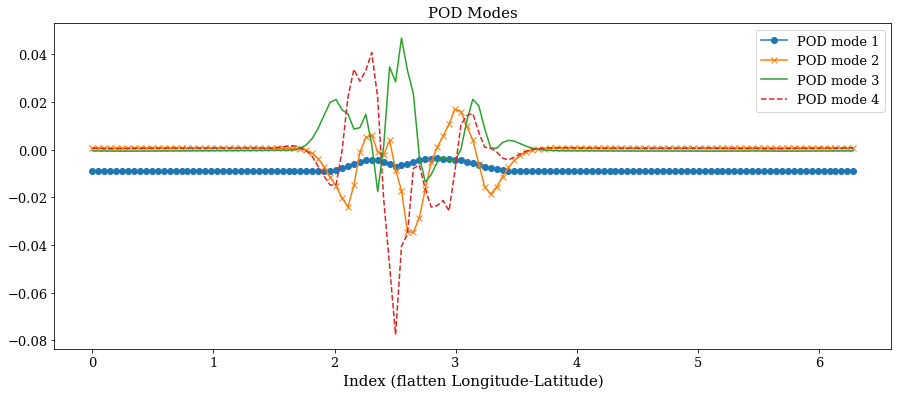

In [31]:
fig, ax = plt.subplots(figsize=(15, 6))

ax.plot(p, Vr[:len(p),0], "-o", label=f"POD mode {1}")
ax.plot(p, Vr[:len(p),1], "-x", label=f"POD mode {2}")
ax.plot(p, Vr[:len(p),2], "-", label=f"POD mode {3}")
ax.plot(p, Vr[:len(p),3], "--", label=f"POD mode {4}")
    
ax.set_xlabel("Index (flatten Longitude-Latitude)", fontsize=15)
ax.set_title("POD Modes", fontsize=15)

plt.legend(loc="upper right")
plt.show()

In [32]:
roi.pre.projection_error(flatten(X_train), Vr)

0.00010441992807433366

In [33]:
flatten(X_train).shape

(14319, 98)

### Calculating the right-hand side Data Matrix

Operator Inference constructs the ROM by solving a least-squares problem that corresponds to the form of the model.
In this case, the original model has the form $\frac{d}{dt}\mathbf{x}(t) = A\mathbf{x}(t)$.
The snapshot matrix $X$ contains data for $\mathbf{x}(t)$, but we also need data for $\frac{d}{dt}\mathbf{x}(t)$.
In this simple example, we can directly compute the _snapshot time derivative matrix_ $\dot{X}\in\mathbb{R}^{n\times k}$ that corresponds to the snapshots by setting $\dot{X} = A X$.

\If the matrix $A$ is unknown or computationally unavailable, the time derivative matrix can be estimated through finite differences of the snapshots.
The `pre` submodule has some convenience tools for this.
Since our time domain is uniformly spaced, we use `roi.pre.xdot_uniform()`; for snapshots that are not uniformly spaced in time, see `roi.pre.xdot_nonuniform()`.

We also note that the finite difference approximation for $\dot{X}$ commutes with the projection to a low-dimensional subspace; in other words, $V_{r}^\mathsf{T}\frac{d}{dt}\left[X\right] = \frac{d}{dt}\left[V_{r}^\mathsf{T}X\right]$.
To save memory, the snapshot matrix may be projected first, and the projected time derivatives can be calculated from the projected snapshots.
The ROM classes in the next section accept both full-order ($n \times k$) or reduced-order ($r\times k$) snapshot and time derivative matrices as training data.

In [34]:
X_ = Vr.T @ flatten(X_train)                                  # Project the state snapshots.
Xdot_ = roi.pre.xdot_uniform(X_, (r[1]-r[0]).value, order = 6) # Estimate the projected time derivatives.

In [35]:
model = roi.InferredContinuousROM("A")
print(model)

Reduced-order model structure: dx / dt = Ax(t)


We now fit the model to the data by solving the least squares problem
$$
    \min_{\hat{A}\in\mathbb{R}^{r\times r}}\left\|\hat{A}\hat{X} - \dot{\hat{X}}\right\|_{F}^2,
$$
where
$$
\begin{align*}
    \hat{X} &= V_r^\mathsf{T}X,
    &
    \dot{\hat{X}} &= V_r^\mathsf{T}\dot{X}.
\end{align*}
$$
This is all done in the `fit()` method, given $X$, $\dot{X}$, and $V_r$.

In [45]:
model.fit(Vr, flatten(X_train), Xdot_, P=1E5)

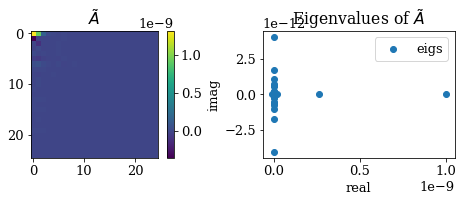

In [46]:
fig, ax = plt.subplots(ncols=2, figsize=(7, 3))
pos = ax[0].imshow(model.A_)
cbar = fig.colorbar(pos, ax=ax[0])
_ = ax[0].set_title(r"$\tilde A$")

# eigendecomposition of A. 
eigA, eigvecA = np.linalg.eig(model.A_)

_ = ax[1].scatter(eigA.real, eigA.imag, label="eigs")
_ = ax[1].set_xlabel("real")
_ = ax[1].set_ylabel("imag")
_ = ax[1].set_title("Eigenvalues of " + r"$\tilde A$")
_ = plt.legend()
_ = plt.tight_layout()

### Simulating the Reduced Model
Once the model is fit, we may simulate the ROM with the `predict()` method, which wraps `scipy.integrate.solve_ivp()`.
This method takes an initial condition from the original space $\mathbb{R}^n$, projects it to $\mathbb{R}^r$, simulates the ROM in $\mathbb{R}^r$, and maps the results to $\mathbb{R}^n$.

In [47]:
X_ROM = model.predict(flatten(X[:, :, 0]).reshape(len(p)*len(t)), r.value, method="BDF")
X_ROM.shape

(14319, 140)

In [48]:
X_ROM = undo_flatten(X_ROM)

/var/folders/tt/hgb4_vc13z77x5wpt5lzk5j40000gn/T/ipykernel_2281/2727364129.py:22: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


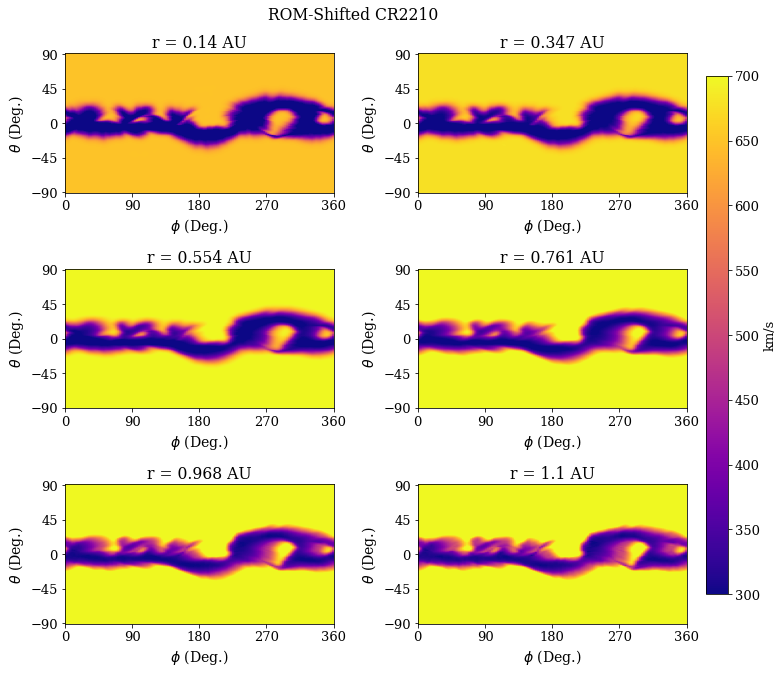

In [49]:
plot_slices_fig(X_ROM, title="ROM-Shifted CR" + cr, figsave="figs/CR" + cr + "/Ax/mhd_2D_XROM_shifted_slices.png")

### Evaluating the Performance of the ROM

To see how the ROM does, we begin by visualizing the simulation output `X_ROM`.
It should look similar to the plot of the snapshot data `X`.

In [50]:
def convert_from_x_to_v(X_ROM):
    # intialize the returned matrix. 
    V_ROM = np.zeros(X_ROM.shape)
    # initial condition
    V_ROM[:,:, 0] = X_ROM[:,:, 0]
    # iterate over all r slices. 
    for jj in range(1, len(r)):
        # compute shift from the linear fit above. 
        shift = shift_function(r[jj].to(u.AU).value, m=m, b=b)
        # define the new shifted coordinate.
        x_new = (p*180/np.pi + shift) % (360)
        # interpolate over the shifted coordinate
        V_ROM[:, :, jj] = interp_fun(p_shifted=x_new, p=p*180/np.pi, t=t, v=X_ROM[:, :, jj]).T
    return V_ROM

In [51]:
V_ROM = convert_from_x_to_v(X_ROM)

/var/folders/tt/hgb4_vc13z77x5wpt5lzk5j40000gn/T/ipykernel_2281/2727364129.py:22: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


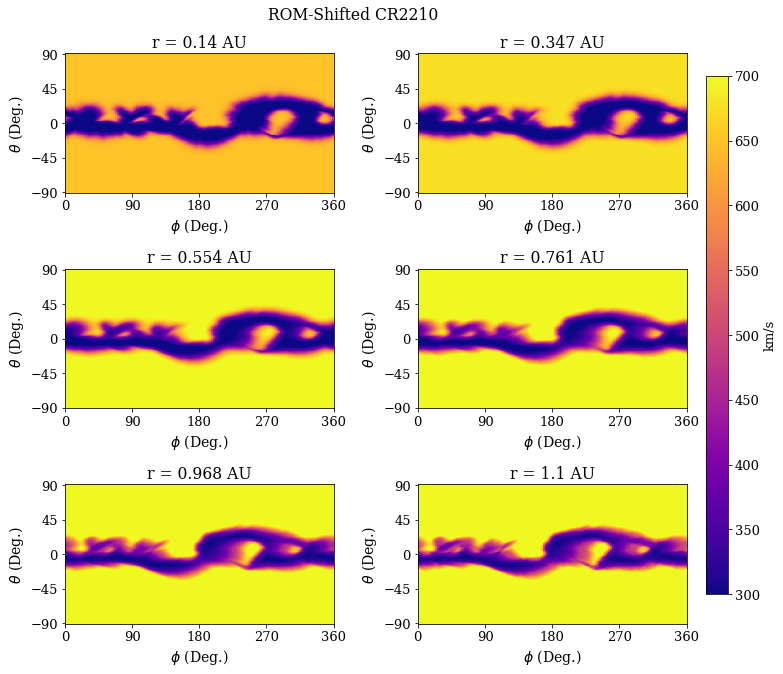

In [52]:
plot_slices_fig(V_ROM, title="ROM-Shifted CR" + cr, figsave="figs/CR" + cr + "/Ax/mhd_2D_VROM_slices.png")

/var/folders/tt/hgb4_vc13z77x5wpt5lzk5j40000gn/T/ipykernel_2281/2727364129.py:22: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


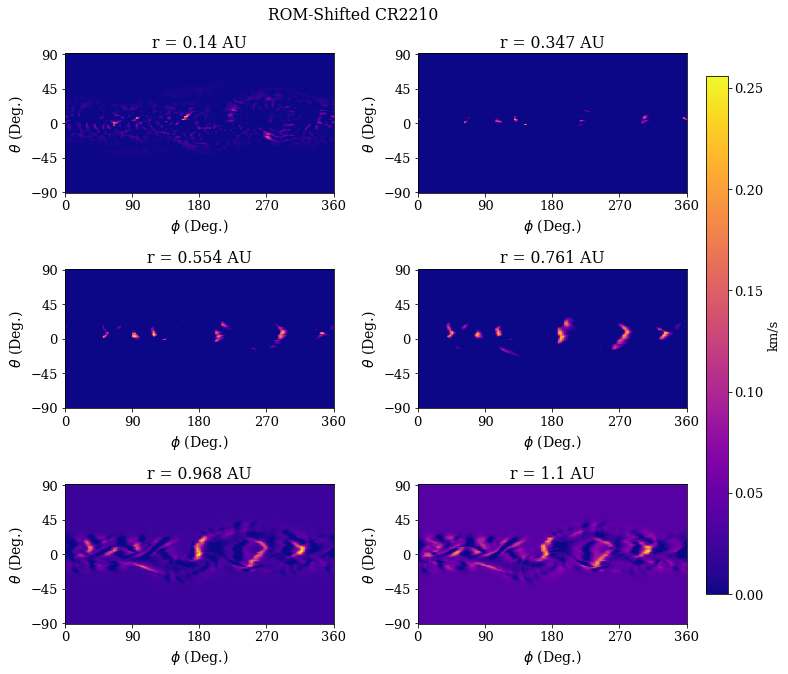

In [53]:
plot_slices_fig((V_ROM-V)/(V), title="ROM-Shifted CR" + cr, figsave="figs/CR" + cr + "/Ax/mhd_2D_relative_error.png", 
               vmin=0, vmax=None)


For more detail, we evaluate the $\ell^2$ error of the ROM output in time, comparing it to the snapshot set.

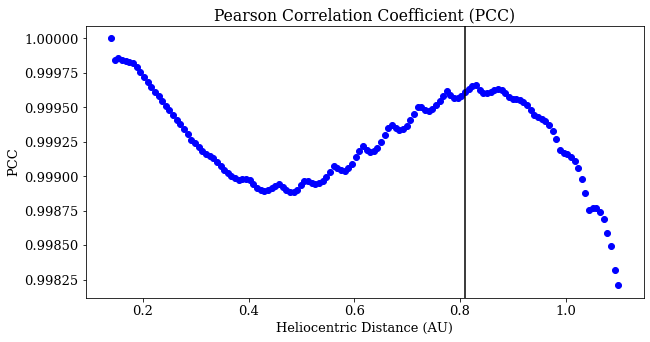

In [54]:
fig, ax = plt.subplots(figsize=(10, 5))
for jj in range(len(r)):
    pcc = stats.pearsonr(np.ndarray.flatten(V[:, :, jj]), np.ndarray.flatten(V_ROM[:, :, jj]))[0]
    ax.scatter(r.to(u.AU).value[jj], pcc, c="b")
_ = ax.axvline(r_train[-1].to(u.AU).value, c="k")
_ = ax.set_xlabel("Heliocentric Distance (AU)")
_ = ax.set_ylabel("PCC")
_ = ax.set_title("Pearson Correlation Coefficient (PCC)")

plt.savefig("figs/CR" + cr + "/Ax/pcc_shifted_operator_inference_mhd.png")

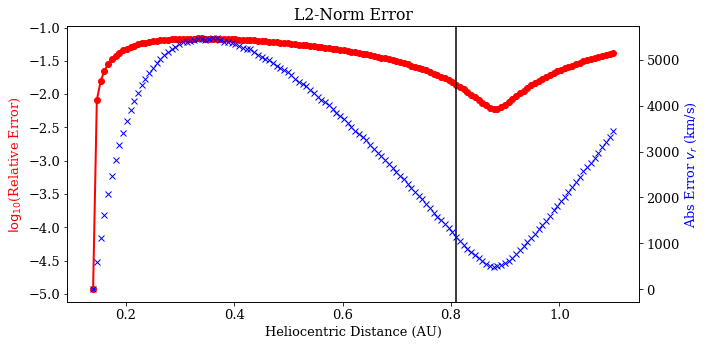

In [55]:
fig, ax = plt.subplots(figsize=(10, 5))

abs_l2err, rel_l2err = roi.post.lp_error(flatten(V), flatten(V_ROM))

_ = ax.plot(r.to(u.AU).value, np.log10(rel_l2err),"-o", linewidth=2, c="r")
_ = ax.axvline(r_train[-1].to(u.AU).value, c="k")
_ = ax.set_title(r"L2-Norm Error")
_ = ax.set_ylabel("$\log_{10}$(Relative Error)", c="r")
_ = ax.set_xlabel("Heliocentric Distance (AU)")

ax2=ax.twinx()
_ = ax2.plot(r.to(u.AU).value, abs_l2err, "x", linewidth=2, c="b")
_ = ax2.set_ylabel("Abs Error $v_{r}$ (km/s)", c="b")

plt.tight_layout()

In [56]:
abs_froerr, rel_froerr = roi.post.frobenius_error(flatten(V), flatten(V_ROM))
print(f"Relative error: {rel_froerr:%}")

Relative error: 4.403767%


In [57]:
print("mean relative error = ", np.mean(np.abs((V.T - V_ROM.T))/np.abs(V.T)))

mean relative error =  0.037973890664489904


# Can we improve prediction by regularization? to avoid overfitting to the training dataset. Find the optimal regularization coefficient $\lambda_{1}$ and rank $r$.

In [58]:
 np.arange(10, 35, 2)

array([10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34])

In [ ]:
coeff_array = 10**np.linspace(4, 9, 100)
rank_array = np.arange(10, 35)

training_error = np.ones((len(coeff_array), len(rank_array))) * np.inf
testing_error = np.ones((len(coeff_array), len(rank_array))) * np.inf

for kk, coeff in enumerate(coeff_array):
    for ii, rank_r in enumerate(rank_array):
        Vr, _ = roi.pre.pod_basis(flatten(X_train), r=rank_r) 
        Xdot = roi.pre.xdot(flatten(X_train), (r_train[1] - r_train[0]).value, order=6) 
        model = roi.InferredContinuousROM(modelform="H")            
        model.fit(Vr, flatten(X_train), Xdot, P=coeff)                          
        X_ROM = model.predict(flatten(X[:, :, 0]).reshape(len(p)*len(t)), r.value, method="BDF", 
                              max_step=(r_train[1] - r_train[0]).value) 
        
        if np.shape(flatten(X_ROM)) == np.shape(flatten(V)):
            V_ROM = convert_from_x_to_v(undo_flatten(X_ROM))
            # save
            training_error[kk, ii] = roi.post.frobenius_error(flatten(V[:, :, :l]), flatten(V_ROM[:, :, :l]))[0]
            # save
            testing_error[kk, ii] = roi.post.frobenius_error(flatten(V[:, :, l:]), flatten(V_ROM[:, :, l:]))[0]

/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/lstsq/_tikhonov.py:185: LinAlgWarning: original least-squares system is underdetermined!
  self._process_fit_arguments(A, B)


In [ ]:
fig, ax = plt.subplots(figsize=(10, 4))

pos = ax.imshow(training_error.T, extent=[coeff_array[0], coeff_array[-1], 
                                          rank_array[-1], rank_array[0]], aspect="auto")

ax.contour(training_error.T, colors='k', extent=[coeff_array[0], coeff_array[-1], 
                                                 rank_array[-1], rank_array[0]], origin="upper")

_ = ax.set_xlabel(r"$\lambda$", fontsize=14)
_ = ax.set_ylabel(r"Basis Dimensions", fontsize=14)
_ = ax.set_title("Training Dataset Error", fontsize=14)
_ = ax.tick_params(axis='both', which='major', labelsize=12)

cbar = fig.colorbar(pos, ax=ax)
cbar.ax.set_ylabel('Absolute Error', rotation=90, fontsize=14)
cbar.ax.tick_params(labelsize=12)
plt.xscale("log")

In [ ]:
min_idx  = np.unravel_index(training_error.argmin(), training_error.shape)

In [ ]:
min_idx_2  = np.unravel_index(testing_error.argmin(), testing_error.shape)

In [ ]:
min_idx_2

In [ ]:
training_error.argmin()

In [ ]:
min_idx

In [ ]:
print("lambda =",  coeff_array[min_idx_2[0]])
print("rank =",  rank_array[min_idx_2[1]])

# Quadratic ROM

In [204]:
# Calculate the cumulative energy.
thresh = .99

cum_energy = np.cumsum(svdvals) / np.sum(svdvals)

# Determine the points at which the cumulative energy passes the threshold.
rank = sum([rank < thresh for rank in cum_energy])
print(f"r = {rank}")

r = 8


In [205]:
Vr, _ = roi.pre.pod_basis(X_train, r=rank)                       # Construct the reduced basis.
Xdot = roi.pre.xdot(X_train, (r_train[1] - r_train[0]).value, order=6)            # Calculate the right-hand side matrix.
model = roi.InferredContinuousROM(modelform="cAH")              # Define the model structure.
model.fit(Vr, X_train, Xdot, P=8e8)                          # Construct the ROM with Operator Inference.
X_ROM = model.predict(X[:, 0], r.value, method="BDF", max_step=(r_train[1] - r_train[0]).value) # Simulate the ROM.

In [206]:
V_ROM = convert_from_x_to_v(X_ROM)

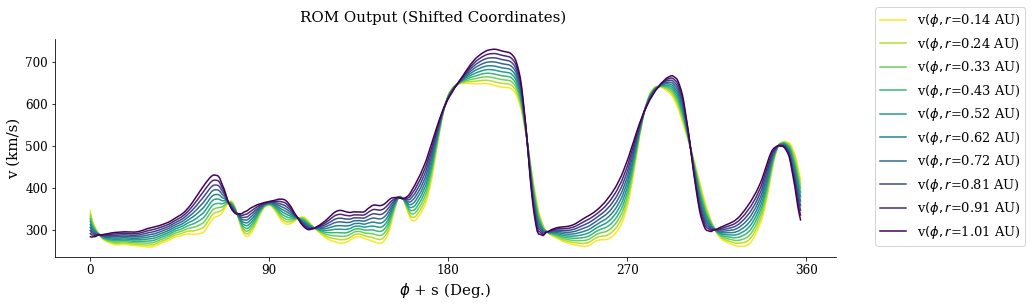

In [207]:
plot_heat_data(X_ROM, "ROM Output (Shifted Coordinates)", variable="v", xlabel="$\phi$ + s (Deg.)")

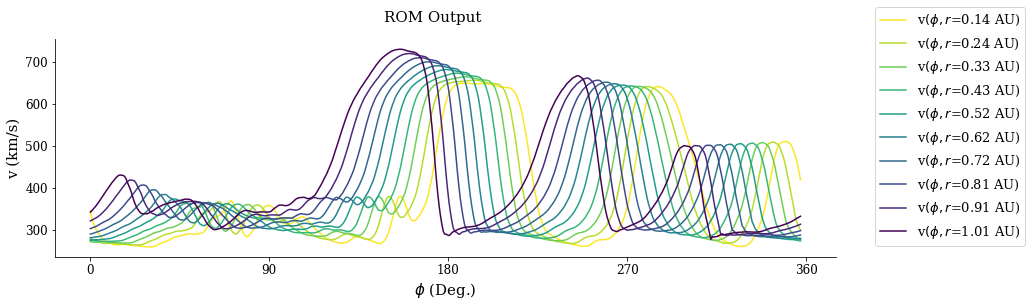

In [208]:
plot_heat_data(V_ROM, "ROM Output", variable="v")

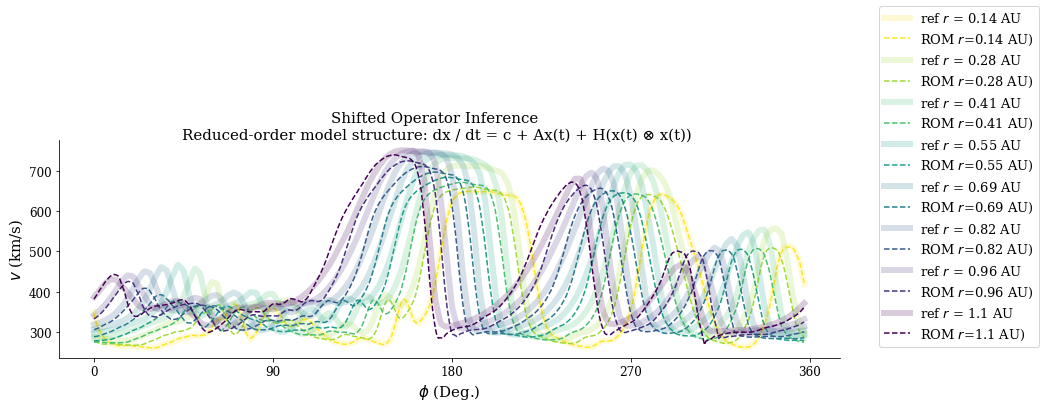

In [209]:
sample_columns = np.arange(0, len(r_new), int(len(r_new)/7))
fig, ax = plt.subplots(1, 1, figsize=(14, 4))
color = iter(plt.cm.viridis_r(np.linspace(0, 1, len(sample_columns))))

for j in sample_columns:
    curr_color =next(color)
    ax.plot(p_new*(180/np.pi), V[:,j], color=curr_color, linewidth=6.0, alpha=0.2, label=r"ref $r$ = "+
            str(round(r_new[j].to(u.AU).value,2)) + " AU")
    ax.plot(p_new*(180/np.pi), V_ROM[:,j], "--", color=curr_color, label=rf"ROM $r$" + "=" + 
            str(round(r_new[j].to(u.AU).value,2)) + " AU)")

ax.set_xlabel("$\phi$ (Deg.)", fontsize=15)
ax.set_xticks([0, 90, 180, 270, 360])
ax.set_ylabel("$v$ (km/s)", fontsize=15)
ax.legend(loc=(1.05, .05))
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
fig.suptitle("Shifted Operator Inference \n" + str(model), fontsize=15)
_ = ax.tick_params(axis='both', which='major', labelsize=12)

fig.savefig("figs/shifted_opinf_results_quadratic_cAH.png", dpi=500, bbox_inches='tight')

In [210]:
V.shape

(500, 500)

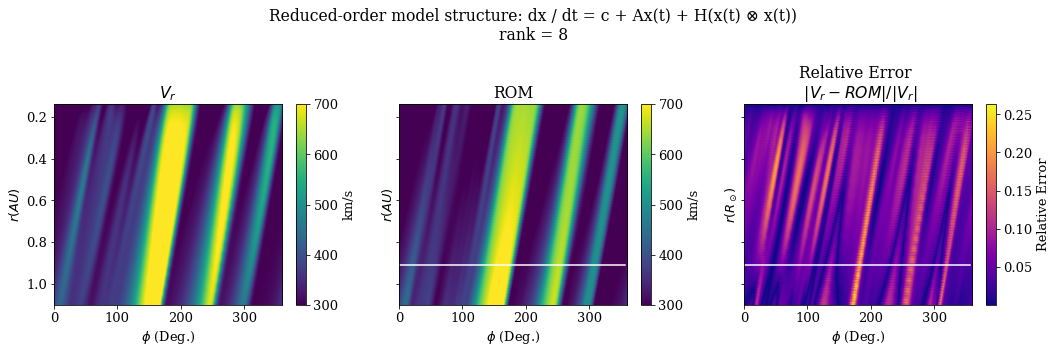

In [211]:
fig, ax = plt.subplots(ncols=3, sharey=True, figsize=(15, 5))
pos = ax[0].imshow(V.T, extent=[0,360,r_new[-1].to(u.AU).value, 
                                r_new[0].to(u.AU).value], vmax=700, vmin=300, aspect="auto")
ax[0].set_xlabel(r"$\phi$ (Deg.)")
ax[0].set_ylabel(r"$r (AU)$")
ax[0].set_title("$V_{r}$")
cbar = fig.colorbar(pos, ax=ax[0])
cbar.ax.set_ylabel('km/s', rotation=90)

pos = ax[1].imshow(V_ROM.T, extent=[0,360,r_new[-1].to(u.AU).value, 
                                    r_new[0].to(u.AU).value], vmax=700, vmin=300, aspect="auto")
ax[1].set_xlabel(r"$\phi$ (Deg.)")
ax[1].set_ylabel(r"$r (AU)$")
ax[1].set_title("ROM")
ax[1].plot(p*(180/np.pi), r_train[-1].to(u.AU).value * np.ones(len(p)), c="white")
cbar = fig.colorbar(pos, ax=ax[1])
cbar.ax.set_ylabel('km/s', rotation=90)

pos = ax[2].imshow(np.abs(V_ROM.T - V.T)/np.abs(V.T), 
                   extent=[0,360,r_new[-1].to(u.AU).value, r_new[0].to(u.AU).value], 
                   cmap="plasma", aspect="auto")
ax[2].set_xlabel(r"$\phi$ (Deg.)")
ax[2].set_ylabel(r"$r (R_\odot)$")
ax[2].set_title("Relative Error \n $|V_{r} - ROM|/|V_{r}|$")
ax[2].plot(p_new*(180/np.pi), r_train[-1].to(u.AU).value * np.ones(len(p_new)), c="white")
cbar = fig.colorbar(pos, ax=ax[2])
cbar.ax.set_ylabel('Relative Error', rotation=90)

plt.suptitle(str(model) + "\n" + "rank = " + str(rank))

plt.tight_layout()

fig.savefig("figs/shifted_opinf_results_quadratic_2D_profile_cAH.png", dpi=500, bbox_inches='tight')

In [212]:
print("mean relative error = ", np.mean(np.abs((V.T - V_ROM.T))/np.abs(V.T)))

mean relative error =  0.05896455650797361


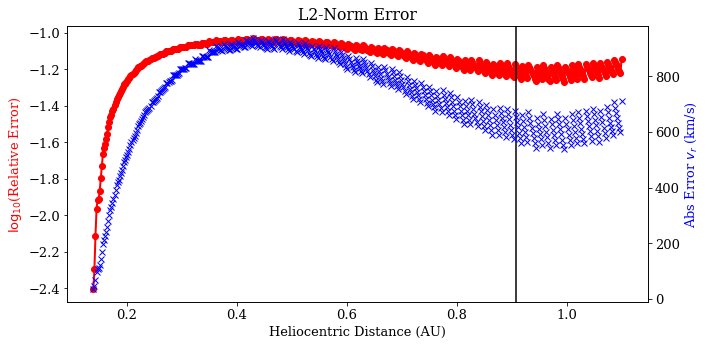

In [213]:
fig, ax = plt.subplots(figsize=(10, 5))
abs_l2err, rel_l2err = roi.post.lp_error(V, V_ROM)
_ = ax.plot(r_new.to(u.AU).value, np.log10(rel_l2err),"-o", linewidth=2, c="r")
_ = ax.axvline(r_train[-1].to(u.AU).value, c="k")
_ = ax.set_title(r"L2-Norm Error")
_ = ax.set_ylabel("$\log_{10}$(Relative Error)", c="r")
_ = ax.set_xlabel("Heliocentric Distance (AU)")

ax2=ax.twinx()
_ = ax2.plot(r_new.to(u.AU).value, abs_l2err, "x", linewidth=2, c="b")
_ = ax2.set_ylabel("Abs Error $v_{r}$ (km/s)", c="b")

plt.tight_layout()

/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)


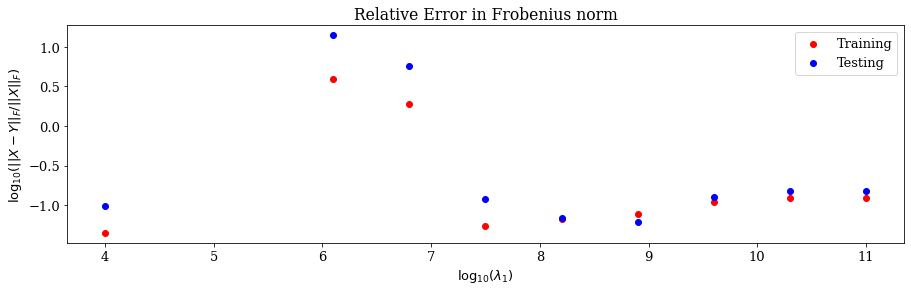

In [214]:
fig, ax = plt.subplots(figsize=(15, 4))

for coeff in 10**np.linspace(4, 11, 11):# get the svd rank based on total cumulative energy. 
    Vr, _ = roi.pre.pod_basis(X_train, r=rank)                       # Construct the reduced basis.
    Xdot = roi.pre.xdot(X_train, (r_train[1] - r_train[0]).value, order=6)            # Calculate the right-hand side matrix.
    model = roi.InferredContinuousROM(modelform="H")              # Define the model structure.
    model.fit(Vr, X_train, Xdot, P=coeff)                          # Construct the ROM with Operator Inference.
    X_ROM = model.predict(X[:, 0], r_new.value, method="BDF", max_step=(r_train[1] - r_train[0]).value) # Simulate the ROM.
    if np.shape(X_ROM) == np.shape(X):
        V_ROM = convert_from_x_to_v(X_ROM)
        ax.scatter(np.log10(coeff), np.log10(roi.post.frobenius_error(V[:, :l], V_ROM[:, :l])[1]), c="r")
        ax.scatter(np.log10(coeff), np.log10(roi.post.frobenius_error(V[:, l:], V_ROM[:, l:])[1]), c="b") 
ax.scatter(0, None, c="r", label="Training")
ax.scatter(0, None, c="b", label="Testing")
_ = ax.set_xlabel("$\log_{10}(\lambda_{1})$")
_ = ax.set_ylabel("$\log_{10}(||X - Y||_{F} / ||X||_{F})$")
_ = ax.set_title("Relative Error in Frobenius norm")
_ = plt.legend()

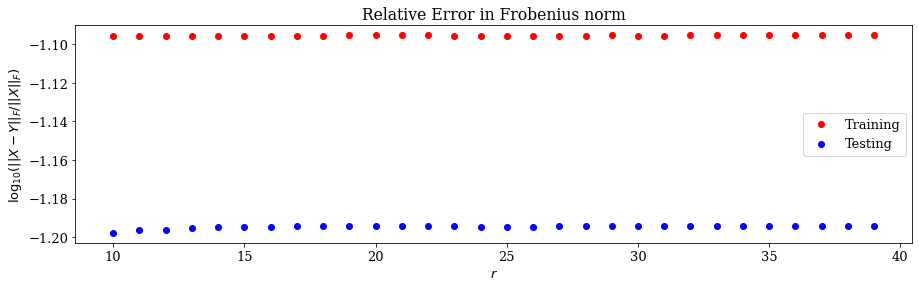

In [201]:
fig, ax = plt.subplots(figsize=(15, 4))

for r_val in np.arange(10, 40):# get the svd rank based on total cumulative energy. 
    Vr, _ = roi.pre.pod_basis(X_train, r=r_val)                       # Construct the reduced basis.
    Xdot = roi.pre.xdot(X_train, (r_train[1] - r_train[0]).value, order=6)            # Calculate the right-hand side matrix.
    model = roi.InferredContinuousROM(modelform="cAH")              # Define the model structure.
    model.fit(Vr, X_train, Xdot, P=1e9)                          # Construct the ROM with Operator Inference.
    X_ROM = model.predict(X[:, 0], r_new.value, method="BDF", max_step=(r_train[1] - r_train[0]).value) # Simulate the ROM.
    if np.shape(X_ROM) == np.shape(X):
        V_ROM = convert_from_x_to_v(X_ROM)
        ax.scatter(r_val, np.log10(roi.post.frobenius_error(V[:, :l], V_ROM[:, :l])[1]), c="r")
        ax.scatter(r_val, np.log10(roi.post.frobenius_error(V[:, l:], V_ROM[:, l:])[1]), c="b") 
ax.scatter(0, None, c="r", label="Training")
ax.scatter(0, None, c="b", label="Testing")
_ = ax.set_xlabel("$r$")
_ = ax.set_ylabel("$\log_{10}(||X - Y||_{F} / ||X||_{F})$")
_ = ax.set_title("Relative Error in Frobenius norm")
_ = plt.legend()

# Sensitivity to Training Data

* **Test 1**: 120 training snapshots. 

* **Test 2**: 150 training snapshots. 

* **Test 3**: 180 training snapshots.

In [98]:
# initialize the training length. 
l1, l2, l3 = int(0.5*len(r_new)), int(0.6*len(r_new)), int(0.7*len(r_new))


X_train1 = X[:, :l1]
X_test1 = X[:, l1:-1]


X_train2 = X[:, :l2]
X_test2 = X[:, l2:-1]


X_train3 = X[:, :l3]
X_test3 = X[:, l3:-1]

In [99]:
r_train1 = r_new[:l1]
r_test1 = r_new[l1:-1]

r_train2 = r_new[:l2]
r_test2 = r_new[l2:-1]

r_train3 = r_new[:l3]
r_test3 = r_new[l3:-1]

In [101]:
# l1 = compute the results for quadradic with 3 modes.
rank=10
Vr, _ = roi.pre.pod_basis(X_train1, r=rank)                       # Construct the reduced basis.
Xdot = roi.pre.xdot(X_train1, (r_train[1] - r_train[0]).value, order=6)  # Calculate the right-hand side matrix.
model = roi.InferredContinuousROM(modelform="H")              # Define the model structure.
model.fit(Vr, X_train1, Xdot, P=1E8)                          # Construct the ROM with Operator Inference.
X_ROM1 = model.predict(X[:, 0], r_new.value, method="BDF") # Simulate the ROM.
V_ROM1 = convert_from_x_to_v(X_ROM1)

# l2 = compute the results for quadradic with 3 modes.
Vr, _ = roi.pre.pod_basis(X_train2, r=rank)                       # Construct the reduced basis.
Xdot = roi.pre.xdot(X_train2, (r_train[1] - r_train[0]).value, order=6)  # Calculate the right-hand side matrix.
model = roi.InferredContinuousROM(modelform="H")              # Define the model structure.
model.fit(Vr, X_train2, Xdot, P=1E8)                          # Construct the ROM with Operator Inference.
X_ROM2 = model.predict(X[:, 0], r_new.value, method="BDF") # Simulate the ROM.
V_ROM2 = convert_from_x_to_v(X_ROM2)

# l3 = compute the results for quadradic with 3 modes.
Vr, _ = roi.pre.pod_basis(X_train3, r=rank)                       # Construct the reduced basis.
Xdot = roi.pre.xdot(X_train3, (r_train[1] - r_train[0]).value, order=6) # Calculate the right-hand side matrix.
model = roi.InferredContinuousROM(modelform="H")              # Define the model structure.
model.fit(Vr, X_train3, Xdot, P=1E8)                          # Construct the ROM with Operator Inference.
X_ROM3 = model.predict(X[:, 0], r_new.value, method="BDF") # Simulate the ROM.
V_ROM3 = convert_from_x_to_v(X_ROM3)

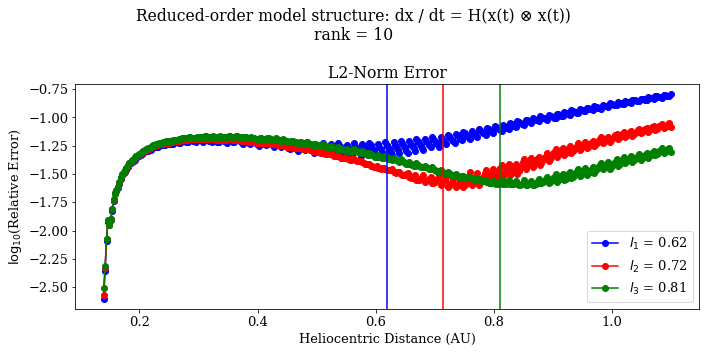

In [102]:
fig, ax = plt.subplots(figsize=(10, 5))
# l1
abs_l2err1, rel_l2err1 = roi.post.lp_error(V, V_ROM1)
_ = ax.plot(r_new.to(u.AU).value, np.log10(rel_l2err1), "-o", c="b", label="$l_{1}$ = " + str(round(r_new[l1].to(u.AU).value, 2)))

#l2
abs_l2err2, rel_l2err2 = roi.post.lp_error(V, V_ROM2)
_ = ax.plot(r_new.to(u.AU).value, np.log10(rel_l2err2), "-o", c="r", label="$l_{2}$ = " + str(round(r_new[l2].to(u.AU).value, 2)))

#l3
abs_l2err3, rel_l2err3 = roi.post.lp_error(V, V_ROM3)
_ = ax.plot(r_new.to(u.AU).value, np.log10(rel_l2err3), "-o", c="g", label="$l_{3}$ = " + str(round(r_new[l3].to(u.AU).value, 2)))

_ = ax.axvline(r_train1[-1].to(u.AU).value, c="b")
_ = ax.axvline(r_train2[-1].to(u.AU).value, c="r")
_ = ax.axvline(r_train3[-1].to(u.AU).value, c="g")
_ = ax.set_title(r"L2-Norm Error")
_ = ax.set_ylabel("$\log_{10}$(Relative Error)")
_ = ax.set_xlabel("Heliocentric Distance (AU)")

plt.legend()
plt.suptitle(str(model) + "\n" + "rank = " + str(rank))
plt.tight_layout()